In [1]:
import os
import datetime
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import albumentations as A

# visualization
import wandb
import dataset_ae
import model
# visualization
import wandb

from importlib import import_module
from tqdm.auto import tqdm

import time
from pytz import timezone

/home/supergalaxy/miniconda/envs/junha_tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
input_size = 2048
code_size = 100
batch_size = 1
LR = 0.001
seed = 0
max_epoch = 300

In [49]:
def wandb_config():
    wandb.init(config={'batch_size':batch_size,
                    'learning_rate':LR,                 #차차 args.~~로 update할 것
                    'seed':seed,
                    'max_epoch':max_epoch},
            project='Segmentation',
            entity='aivengers_seg',
            name=f"AE_MSE_tf={input_size}_cln=True_e={max_epoch}_sd={seed}"
            )

In [141]:
def make_dataset(input_size = 1024):
    # dataset load
    tf = A.Resize(input_size, input_size)
    
    train_dataset = dataset_ae.AEDataset(transforms=tf)
    test_dataset = dataset_ae.AE_TRAIN_Dataset(transforms=tf)
        

    train_loader = DataLoader(
        dataset=train_dataset, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        drop_last=True,
    )
    test_loader = DataLoader(
        dataset=test_dataset, 
        batch_size=1,
        shuffle=False,
        num_workers=0,
        drop_last=False
    )

    return [train_loader, test_loader]

In [51]:
model = torch.load('/home/supergalaxy/junha/input/weights/AE_MSE_tf=2048_cln=True_e=300_sd=0.pt')
model = model.cuda()

data_loader, valid_loader = make_dataset(input_size)


#########################################################
Data Cleaning....
#########################################################
#########################################################
Data Cleaning....
#########################################################


In [52]:
from torchvision import transforms
import matplotlib.pyplot as plt
tf = transforms.ToPILImage()

NameError: name 'b' is not defined

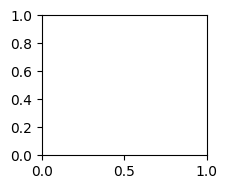

In [53]:
n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    img_origin = tf(b[i]*255)
    plt.imshow(img_origin)
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    img_pred = tf(r[0][i]*255)
    plt.imshow(img_pred)
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [54]:
pretrained_model = torch.load('/home/supergalaxy/junha/input/weights/AE_MSE_tf=2048_cln=True_e=300_sd=0.pt')
pretrained_model = pretrained_model.cuda()

train_loader, valid_loader = make_dataset(input_size)

#########################################################
Data Cleaning....
#########################################################
#########################################################
Data Cleaning....
#########################################################


In [61]:
def set_c(model, dataloader, eps=0.1):
        
    # 구의 중심점을 초기화함
    model.eval()
    z_ = []
    with torch.no_grad():
        for x in dataloader:
            x = x.float().cuda()
            z = model.encoder(x)
            z = torch.flatten(z, 1)
            z = model.latent(z)
            z_.append(z.detach())
    z_ = torch.cat(z_)
    c = torch.mean(z_, dim=0)
    c[(abs(c) < eps) & (c < 0)] = -eps
    c[(abs(c) < eps) & (c > 0)] = eps
    return c

In [62]:
class Encoder(nn.Module):
    def __init__(self, input_size = 2048, code_size = 32):
        super(Encoder, self).__init__()

        # 입력 이미지 크기
        self.input_size = input_size
        self.code_size = code_size

        # 인코더
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 잠재 변수
        self.latent = nn.Linear(4 * (self.input_size // 8) * (self.input_size // 8), self.code_size)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        print(x.shpea)
        latent_var = self.latent(x)
        return latent_var

In [63]:
c = set_c(model = pretrained_model,dataloader = train_loader)
net = Encoder(2048).cuda()
state_dict = pretrained_model.encoder.state_dict()
net.encoder.load_state_dict(state_dict, strict=False)

state_dict = pretrained_model.latent.state_dict()
net.latent.load_state_dict(state_dict, strict=False)


torch.save({'center': c.cpu().data.numpy().tolist(),
            'net_dict': net.state_dict()}, '/home/supergalaxy/junha/input/weights/pretrained_parameters.pth')

In [64]:
net = Encoder(2048).cuda()
state_dict = torch.load('/home/supergalaxy/junha/input/weights/pretrained_parameters.pth')
net.load_state_dict(state_dict['net_dict'])
c = torch.Tensor(state_dict['center']).cuda()

In [65]:
optimizer = optim.Adam(net.parameters(), lr=1e-4,
                        weight_decay=0.5e-6)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
            milestones=[50], gamma=0.1)



In [67]:
net.train()
for epoch in range(150):
    total_loss = 0
    for x in (train_loader):
        x = x.float().cuda()

        optimizer.zero_grad()
        z = net(x)
        loss = torch.mean(torch.sum((z - c) ** 2, dim=1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    scheduler.step()
    print('Training Deep SVDD... Epoch: {}, Loss: {:.3f}'.format(
            epoch, total_loss/len(train_loader)))
    
torch.save({'center': c.cpu().data.numpy().tolist(),
            'net_dict': net.state_dict()}, '/home/supergalaxy/junha/input/weights/final.pth')

Training Deep SVDD... Epoch: 0, Loss: 155325.406
Training Deep SVDD... Epoch: 1, Loss: 30521.313
Training Deep SVDD... Epoch: 2, Loss: 15848.832
Training Deep SVDD... Epoch: 3, Loss: 10202.621
Training Deep SVDD... Epoch: 4, Loss: 7422.894
Training Deep SVDD... Epoch: 5, Loss: 5829.747
Training Deep SVDD... Epoch: 6, Loss: 4694.831
Training Deep SVDD... Epoch: 7, Loss: 4230.510
Training Deep SVDD... Epoch: 8, Loss: 3528.037
Training Deep SVDD... Epoch: 9, Loss: 3018.624
Training Deep SVDD... Epoch: 10, Loss: 3024.464
Training Deep SVDD... Epoch: 11, Loss: 2682.563
Training Deep SVDD... Epoch: 12, Loss: 2566.380
Training Deep SVDD... Epoch: 13, Loss: 2472.342
Training Deep SVDD... Epoch: 14, Loss: 2255.501
Training Deep SVDD... Epoch: 15, Loss: 2366.505
Training Deep SVDD... Epoch: 16, Loss: 2078.273
Training Deep SVDD... Epoch: 17, Loss: 1790.125
Training Deep SVDD... Epoch: 18, Loss: 1709.354
Training Deep SVDD... Epoch: 19, Loss: 1586.758
Training Deep SVDD... Epoch: 20, Loss: 1685.4

In [1]:
from sklearn.metrics import roc_auc_score
import dataset_ae
import os
import datetime
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import albumentations as A

# visualization
import wandb
import dataset_ae
import model
# visualization
import wandb

from importlib import import_module
from tqdm.auto import tqdm

import time
from pytz import timezone

/home/supergalaxy/miniconda/envs/junha_tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def make_dataset(input_size = 1024):
    # dataset load
    tf = A.Resize(input_size, input_size)
    
    train_dataset = dataset_ae.AEDataset(transforms=tf)
    test_dataset = dataset_ae.AE_Test_Dataset(transforms=tf)
        

    train_loader = DataLoader(
        dataset=train_dataset, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        drop_last=True,
    )
    test_loader = DataLoader(
        dataset=test_dataset, 
        batch_size=1,
        shuffle=False,
        num_workers=0,
        drop_last=False
    )

    return [train_loader, test_loader]

In [4]:
input_size = 2048
code_size = 100
batch_size = 1
LR = 0.001
seed = 0
max_epoch = 300

In [5]:
train_loader, test_loader = make_dataset(input_size)

#########################################################
Data Cleaning....
#########################################################


In [6]:
def eval(net, c, dataloader):
   # ROC AUC score 계산
    net.eval()
    with torch.no_grad():
        for x in dataloader:
            x = x.float().cuda()
            z = net.encoder(x)
            z = torch.flatten(z, 0)
            z = net.latent(z)
            score = torch.sum((z - c) ** 2, dim=0)
    return score


In [7]:
net = model.Encoder(2048).cuda()
state_dict = torch.load('/home/supergalaxy/junha/input/weights/final.pth')
net.load_state_dict(state_dict['net_dict'])
c = torch.Tensor(state_dict['center']).cuda()
# data = next(iter(train_loader))
# junk = torch.zeros(1,3,2048,2048)
# true_scores = eval(net, c, data)
# junk_scores = eval(net, c, junk)

In [14]:
scores = []
for i in tqdm(train_loader):
    scores.append(eval(net, c, i))

100%|██████████| 780/780 [00:24<00:00, 31.94it/s]


In [16]:
sorted(scores)[-10:]

[tensor(13.6513, device='cuda:0'),
 tensor(14.7160, device='cuda:0'),
 tensor(15.1352, device='cuda:0'),
 tensor(15.3475, device='cuda:0'),
 tensor(15.7734, device='cuda:0'),
 tensor(16.4569, device='cuda:0'),
 tensor(23.1599, device='cuda:0'),
 tensor(24.6859, device='cuda:0'),
 tensor(105.1541, device='cuda:0'),
 tensor(122.4361, device='cuda:0')]

In [18]:
junk_scores = []
for i in tqdm(test_loader):
    junk_scores.append(eval(net, c, i))

100%|██████████| 20/20 [00:01<00:00, 11.99it/s]


In [22]:
(sorted(scores)[-10:], sorted(junk_scores))

([tensor(13.6513, device='cuda:0'),
  tensor(14.7160, device='cuda:0'),
  tensor(15.1352, device='cuda:0'),
  tensor(15.3475, device='cuda:0'),
  tensor(15.7734, device='cuda:0'),
  tensor(16.4569, device='cuda:0'),
  tensor(23.1599, device='cuda:0'),
  tensor(24.6859, device='cuda:0'),
  tensor(105.1541, device='cuda:0'),
  tensor(122.4361, device='cuda:0')],
 [tensor(20.7620, device='cuda:0'),
  tensor(24.8690, device='cuda:0'),
  tensor(38.7881, device='cuda:0'),
  tensor(47.3702, device='cuda:0'),
  tensor(55.4163, device='cuda:0'),
  tensor(88.4913, device='cuda:0'),
  tensor(103.2564, device='cuda:0'),
  tensor(153.7067, device='cuda:0'),
  tensor(189.5698, device='cuda:0'),
  tensor(357.6611, device='cuda:0'),
  tensor(507.3883, device='cuda:0'),
  tensor(609.1959, device='cuda:0'),
  tensor(710.6279, device='cuda:0'),
  tensor(1138.6589, device='cuda:0'),
  tensor(1419.4535, device='cuda:0'),
  tensor(1672.8865, device='cuda:0'),
  tensor(1852.2726, device='cuda:0'),
  tensor(4